# Model of recall and cost

**Problem:** find the top-$K$ from $N$ elements (optionally in a batch of $B$ independent tasks).

**Approximate method:**
 1. Split $N$ elements into $L$ buckets (assume $L$ divides $N$), and compute the top-$J$ for each bucket (of size $N/L$).
 2. If $L\, J > K$, get the top-$K$ of these candidates.

**Metric:** _Recall_, if $S^*$ is a set of the true top-$K$ and $S$ is the set returned from our algorithm, recall $R = |S^* \cap S|/|S^*|$.

**Cost models:**

 | Model | Algorithm | Cost | Ignored |
 | --- | --- | --- | --- |
 | Basic | - | $B\,N(\log_2 K + 1)$ | $+O(K)$ |
 | Serial | Insertion sort | $B\,N(4\,K-2)$ | $+O(1)$ |
 | Serial | Radix select & filter | $B\,N(4 \log_2 N + 4)$ | $+O(\log_2 N)$ |
 | Parallel | Scan-max | $K (2\log_2 N + 2)$ | $+O(1)$ |
 | Parallel | Radix select & filter | $\log_2 N (2\log_2 N + 16)$ | $+O(1)$ |

_(see explanation below)_

The cost $C$ of exact top-$K$ under each model is:

$C^{\mathrm{b}} = B\,N(\log_2 K + 1)$

$C^{\mathrm{s}} = B\,N\min(4\,K-2 ,\, 4 \log_2 N + 4)$

$C^{\mathrm{p}} = \min(K (2\log_2 N + 2) ,\, \log_2 N (2\log_2 N + 16))$

And for approximate top-$K$, given $L$ and $J$:

$C^{\mathrm{b}} = B\,N(\log_2 J + 1) + \delta(L\,J>K) B\,L\,J(\log_2 K + 1)$

$C^{\mathrm{s}} = B\,N\min(4\,J-2 ,\, 4 \log_2 L + 4) + \delta(L\,J>K) B\,L\,J\min(4\,K-2 ,\, 4 \log_2 (L\,J) + 4)$

$C^{\mathrm{p}} = \min(J (2\log_2 L + 2) ,\, \log_2 L (2\log_2 L + 16)) + \delta(L\,J>K) \min(K (2\log_2 (L\,J) + 2) ,\, \log_2 (L\,J) (2\log_2 (L\,J) + 16))$


---

## Explaining the cost model

**Model:**

 - Iterating through the input data linearly is free.
 - If statements are free, but all branches are "taken".
 - Fixed-offset addressing is free.
 - Ops that count (1): `{==, <, >, &, |, not, =}`.
 - Ops that count (2): `{+=, &=, |=, ^=}`.
 - Ignore some tail complexity terms (see table above).

**Variants:**

 - _Basic_: computational complexity (note: $N (\log K + 1)$ so that $K=1$ has nonzero cost; $K=2$ is twice as expensive as $K=1$).
 - _Serial_: total operations.
 - _Parallel_: longest-path cost (number of timesteps), assuming infinite parallel processors.

**Insertion sort (serial)**

```python
for i, x in data:  # N*
    if x > topk[0]:                 # +1
        topk[0] = (x, i)            # +1
    if topk[0] > topk[1]:           # +1
        swap(topk[0], topk[1])      # +3
    ...
    if topk[k-2] > topk[k-1]:       # +1
        swap(topk[k-2], topk[k-1])  # +3
```

**Scan-max (parallel)**

```python
for i in range(k):  # K*
    j = scan_argmax(data)        # +2*log2(N)
    topk[i] = (data[j], j)       # +1
    data[j] = -inf               # +1
```

**Radix select (serial)**

```python
# Radix select (base 2)
partition = 0
partition_mask = 0
count_left = 0
for r in range(log(N)-1, -1, -1):  # log(N)* (bits required to find partition)
    count_1 = 0
    mask = 1 << r                            # +1 (ignore)
    partition |= mask                        # +2 (ignore)
    partition_mask |= mask                   # +2 (ignore)
    for x in data:                           # N*
        if x & partition_mask == partition:  #   +2
            count_1 += 1                     #   +2
    
    count_0 = N - count_1                    # +1 (ignore)
    if K < count_left + count_0:             # +2 (ignore)
        partition ^= mask                    # +2 (ignore)
    else:
        count_left += count_0                # +2 (ignore)

# - scan (note: a second scan may be needed for ties)
ptr = 0
for i, x in data:          # N*
    if x > partition:      #   +1
        out[ptr] = (x, i)  #   +1
        ptr += 1           #   +2
```

**Radix select (parallel)**

```python
partition = 0
partition_mask = 0
count_left = 0
for r in range(log(N)-1, -1, -1):  # log(N)* (bits required to find partition)
    mask = 1 << r                                               # +1
    partition |= mask                                           # +2
    partition_mask |= mask                                      # +2

    count_1s = [x & partition_mask == partition for x in data]  # +2
    count_1 = scan_sum(count_1s)                                # +2log(N)

    count_0 = N - count_1                                       # +1
    if K < count_left + count_0:                                # +2
        partition ^= mask                                       # +2
    else:
        count_left += count_0                                   # +2

# - scan (note: a second scan may be needed for ties)
in_topk = [x > partition for x in data]
offset = scan_cumsum(in_topk)                                   # +2log(N)
[topk[o] = (x, i) for (x, i), o in zip(data, offset)]
```

---

## Experiments

In [66]:
from collections import Counter
from functools import lru_cache
from math import log2
import random
from typing import Any, Iterable

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.stats
import seaborn as sns

matplotlib.rcParams.update({"legend.frameon": False, "axes.spines.right": False, "axes.spines.top": False})

class LogPaletteMap:
    def __init__(self, values: np.ndarray, n: int):
        self.palette = sns.color_palette("flare", n_colors=n)
        self.logV_to_hue = {
            logV: self.palette[min(logV, len(self.palette) - 1)]
            for logV in sorted(map(int, np.log2(values.dropna().unique())))}

    def __call__(self, value: float) -> tuple[float, float, float]:
        return self.logV_to_hue[int(np.log2(value))]

    def map_legend(self, handles: list[object], labels: list[str]) -> tuple[list[object], list[str]]:
        return handles[:len(self.palette)], labels[:len(self.palette) - 1] + [f"$\\geq${labels[len(self.palette) - 1]}"]


@lru_cache(maxsize=2**24)
def binom_cdf(k: int, n: int, p: float) -> float:
    return scipy.stats.binom.cdf(k, n, p)


def recall_model(K: int, L: int, J: int) -> float:
    return (J + sum([binom_cdf(J-1, i, p=1/L) for i in range(J, K)])) / K


def recall_simulation(K: int, L: int, J: int, reps: int) -> float:
    recalls = []
    for _ in range(reps):
        counts = Counter(random.randint(0, L-1) for _ in range(K))
        recalls.append(sum(min(v, J) for v in counts.values()) / K)
    return sum(recalls) / len(recalls)

class costs:
    @classmethod
    def approx_topk(cls, K: int, N: int, B: int, L: int, J: int) -> int:
        return cls.topk(K=J, N=(N//L), B=B*L) + (J*L>K) * cls.topk(K=K, N=J*L, B=B)


class costs_basic(costs):
    @staticmethod
    def topk(K: int, N: int, B: int) -> int:
        return B * N * (log2(K) + 1)


class costs_serial(costs):
    @staticmethod
    def insertion(K: int, N: int, B: int) -> int:
        return B * N * (4*K - 2)

    @staticmethod
    def radix(K: int, N: int, B: int) -> int:
        return B * N * (4*log2(N) + 4)

    @classmethod
    def topk(cls, K: int, N: int, B: int) -> int:
        return min(cls.insertion(K=K, N=N, B=B), cls.radix(K=K, N=N, B=B))


class costs_parallel(costs):
    @staticmethod
    def scan(K: int, N: int, B: int) -> int:
        return K * (2*log2(N) + 2)

    @staticmethod
    def radix(K: int, N: int, B: int) -> int:
        return log2(N) * (2*log2(N) + 16)

    @classmethod
    def topk(cls, K: int, N: int, B: int) -> int:
        return min(cls.scan(K=K, N=N, B=B), cls.radix(K=K, N=N, B=B))

In [116]:
def _analyse(N: int, K: int, B: int) -> Iterable[dict[str, Any]]:
    yield dict(
        algorithm="exact",
        recall=1.0,
        cost_b=costs_basic.topk(K=K, N=N, B=B),
        cost_s=costs_serial.topk(K=K, N=N, B=B),
        cost_p=costs_parallel.topk(K=K, N=N, B=B),
    )
    for L in [2**i for i in range(1, int(log2(N)) + 1)]:
        for J in [2**i for i in range(0, int(log2(K)) + 1)]:
            if L * J >= K and (J < N//L):
                yield dict(
                    algorithm="approx",
                    L=L,
                    J=J,
                    recall=recall_model(K=K, L=L, J=J),
                    cost_b=costs_basic.approx_topk(K=K, N=N, B=B, L=L, J=J),
                    cost_s=costs_serial.approx_topk(K=K, N=N, B=B, L=L, J=J),
                    cost_p=costs_parallel.approx_topk(K=K, N=N, B=B, L=L, J=J),
                )

df = pd.DataFrame.from_records(
    dict(N=N, K=K, B=B, **m)
    for N in [2**i for i in [10, 12, 14, 16]]
    for K in [2**i for i in range(0, int(log2(N)), 2)]
    for B in [1]
    for m in _analyse(N=N, K=K, B=B)
)
print(len(df))
df.head()

980


,N,K,B,algorithm,recall,cost_b,cost_s,cost_p,L,J
0,1024,1,1,exact,1.0,1024.0,2048.0,22.0,NaN,NaN
1,1024,1,1,approx,1.0,1026.0,2052.0,24.0,2.0,1.0
2,1024,1,1,approx,1.0,1028.0,2056.0,24.0,4.0,1.0
3,1024,1,1,approx,1.0,1032.0,2064.0,24.0,8.0,1.0
4,1024,1,1,approx,1.0,1040.0,2080.0,24.0,16.0,1.0


## Cost models (exact)

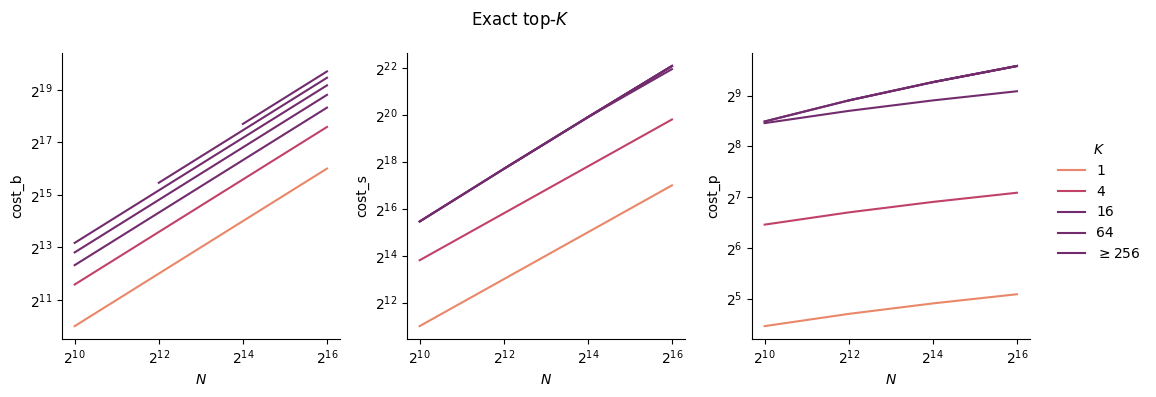

In [ ]:
fig, axs = plt.subplots(ncols=3, figsize=(3*3.5, 4))
palette_map = LogPaletteMap(df["K"], n=5)
for y, ax in zip(["cost_b", "cost_s", "cost_p"], axs):
    for K, g in df[df.algorithm=="exact"].groupby("K"):
        ax.plot(g["N"], g[y], color=palette_map(K), label=str(K))
    ax.set_ylabel(y)
    ax.set_xlabel("$N$")
    ax.set_xscale("log", base=2)
    ax.set_yscale("log", base=2)
    ax.set_xticks(df["N"].unique())

fig.legend(*palette_map.map_legend(*axs[0].get_legend_handles_labels()), title="$K$", loc="center left", bbox_to_anchor=(1.0, 0.5))
fig.suptitle("Exact top-$K$")
plt.tight_layout()

## Approx topk trade-offs

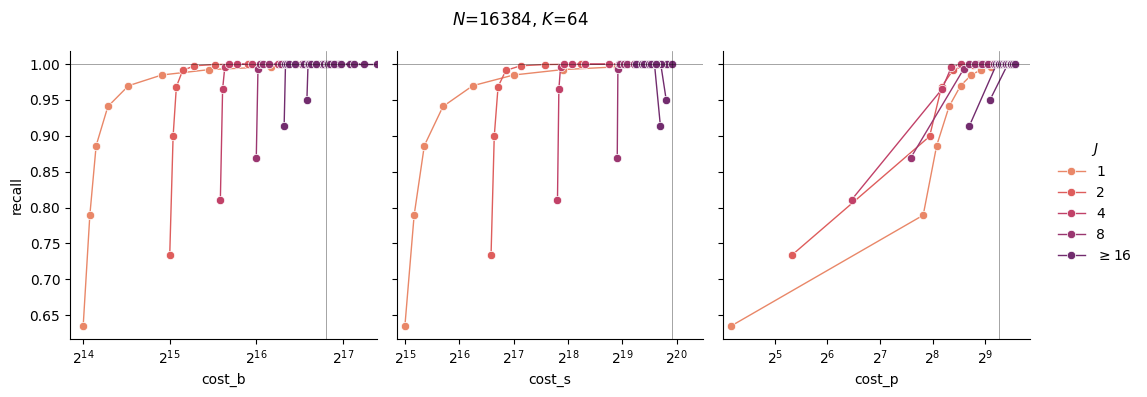

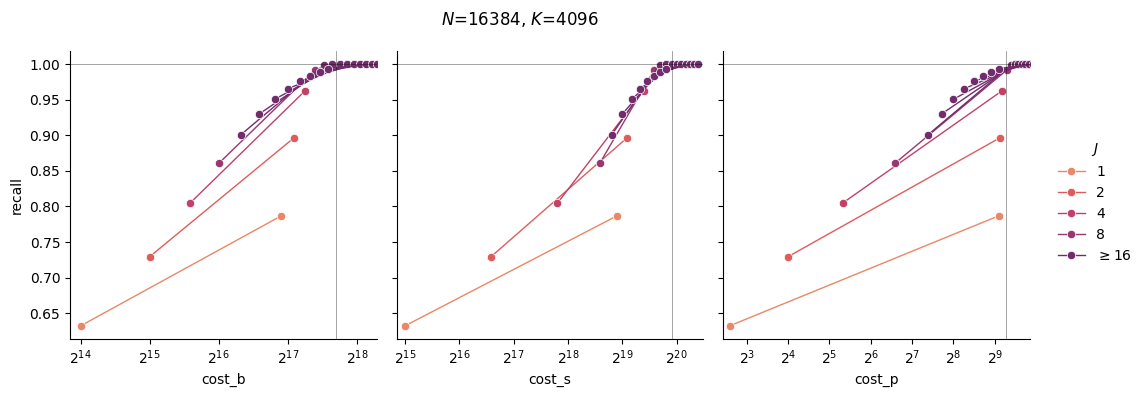

In [164]:
def show_tradeoff(d: pd.DataFrame, cost: str, J_map: LogPaletteMap, ax: matplotlib.axes.Axes) -> None:
    exact_cost = float(d[d["algorithm"]=="exact"][cost].iloc[0])
    for j, g in d.groupby("J"):
        ax.plot(g[cost], g["recall"], color=J_map(j), label=f"{j:.0f}", marker="o", ms=6, mew=.5, mec="w", lw=1)
    ax.axvline([exact_cost], color="k", lw=.5, alpha=.5)
    ax.axhline([1.0], color="k", lw=.5, alpha=.5)
    ax.set_xlabel(cost)
    ax.set_ylabel("recall")
    ax.set_xscale("log", base=2)
    ax.set_xlim((d[cost].min() * .9, exact_cost * 1.5))

for N, K in [(16384, 64), (16384, 4096)]:
    d = df[(df.N==N) & (df.K==K)]
    J_map = LogPaletteMap(d["J"], n=5)
    fig, axs = plt.subplots(ncols=3, figsize=(3*3.5, 4), sharey=True)
    for cost, ax in zip(["cost_b", "cost_s", "cost_p"], axs):
        show_tradeoff(d, cost, J_map, ax=ax)
        if ax is not axs[0]:
            ax.set_ylabel("")
    fig.legend(*J_map.map_legend(*axs[0].get_legend_handles_labels()), title="$J$", loc="center left", bbox_to_anchor=(1.0, 0.5))
    fig.suptitle(f"$N$={N}, $K$={K}")
    plt.tight_layout()

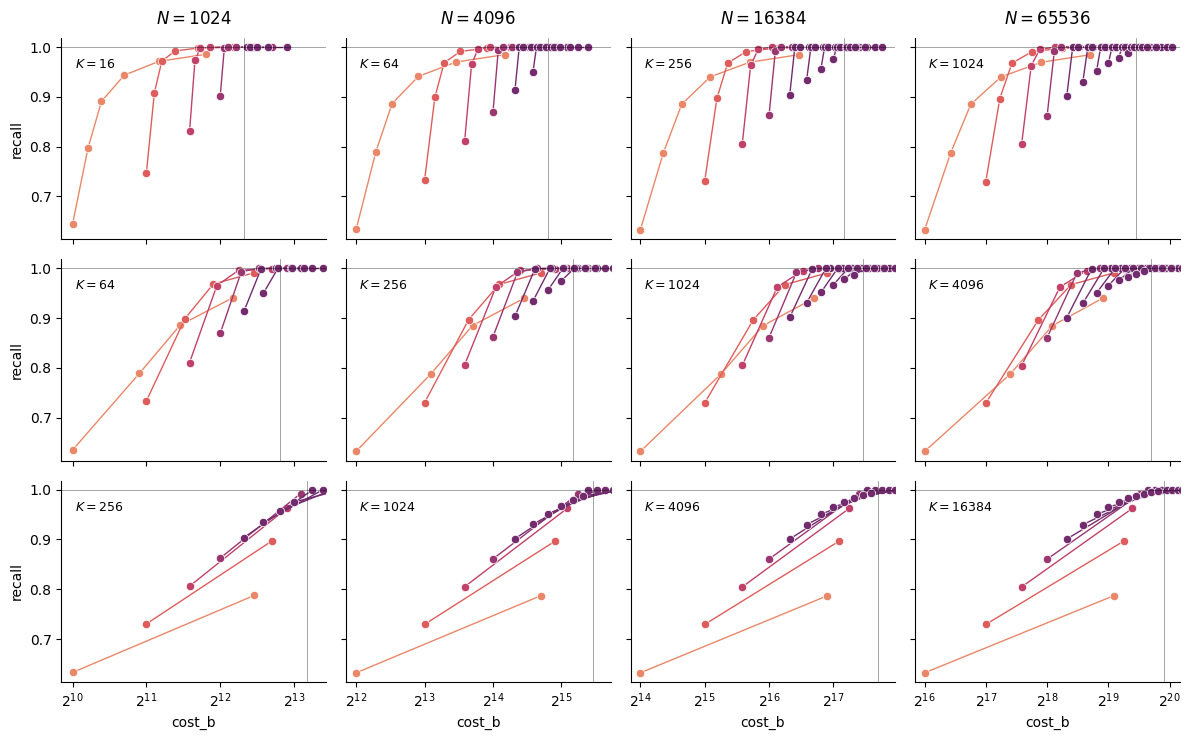

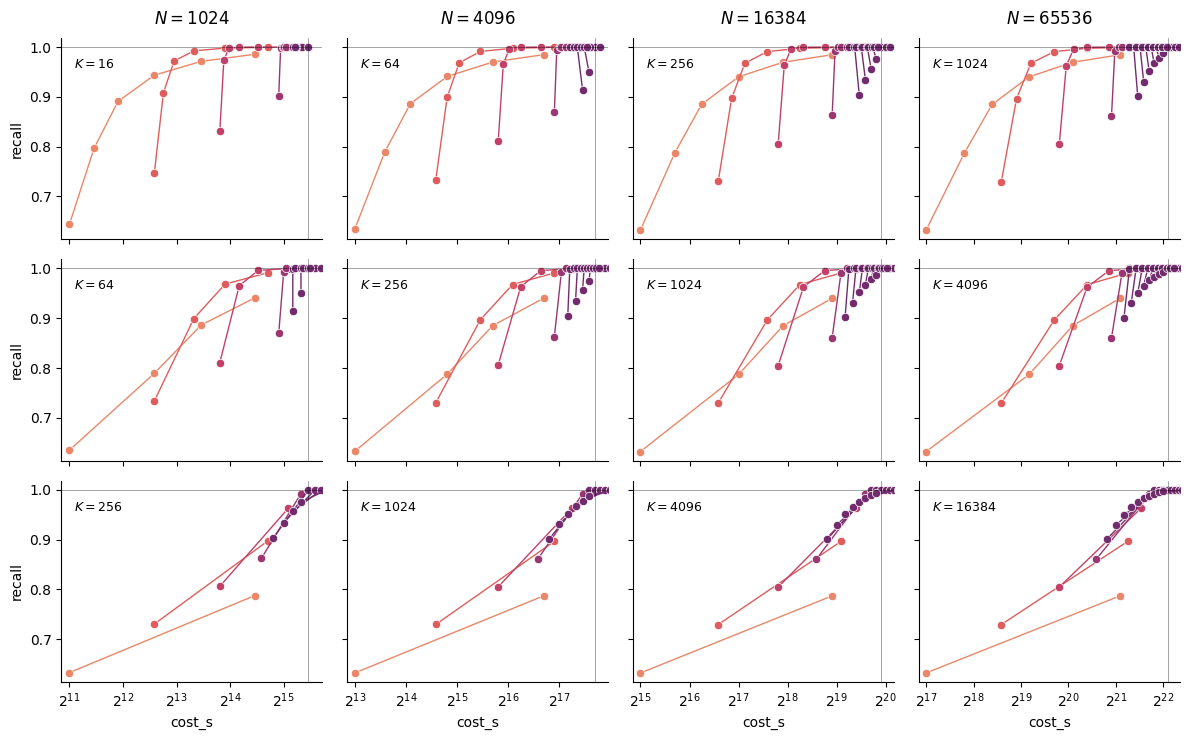

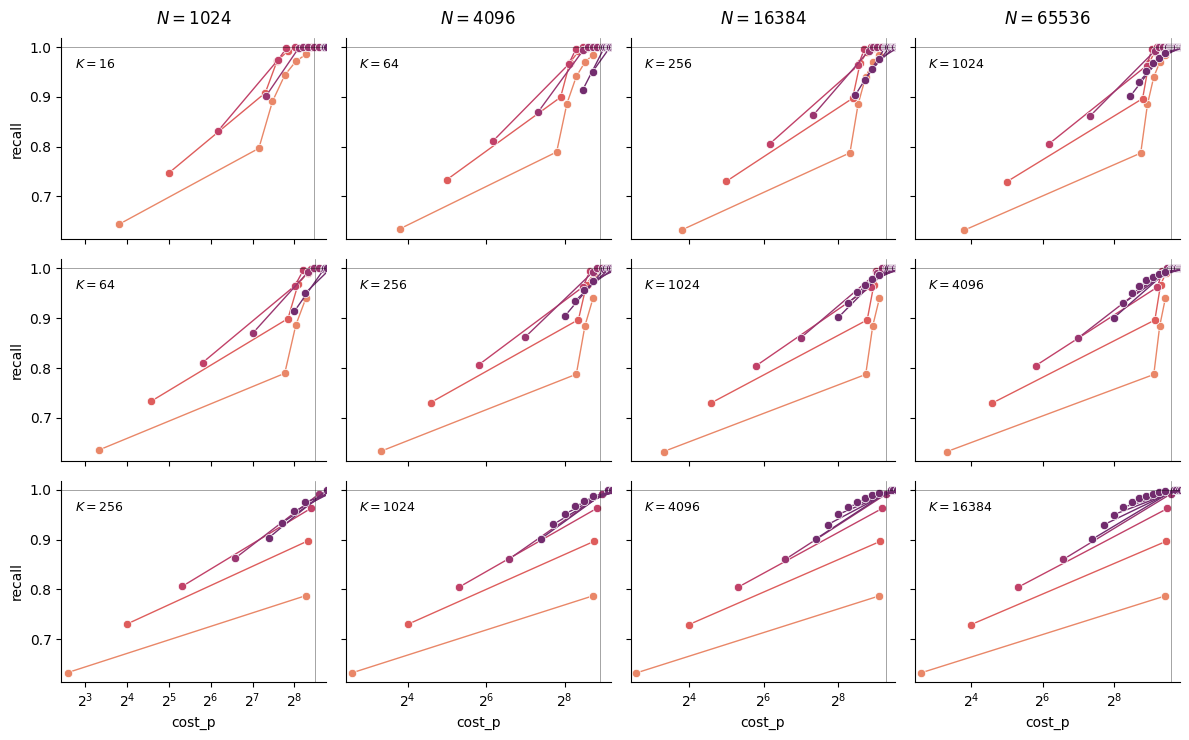

In [182]:
for cost in ["cost_b", "cost_s", "cost_p"]:
    Ns = sorted(df["N"].unique())
    K_over_Ns = [1/64, 1/16, 1/4]
    J_map = LogPaletteMap(df["J"], n=5)
    _, axs = plt.subplots(ncols=len(Ns), nrows=len(K_over_Ns), figsize=(3*len(Ns), 2.5*len(K_over_Ns)), sharey=True, sharex="col")
    for K_over_N, axr in zip(K_over_Ns, axs):
        for N, ax in zip(Ns, axr):
            K = int(K_over_N * N)
            show_tradeoff(df[(df["N"]==N) & (df["K"] == K)], cost=cost, J_map=J_map, ax=ax)
            if ax is not axr[0]:
                ax.set_ylabel("")
            if K_over_N == K_over_Ns[0]:
                ax.set_title(f"$N={N}$", pad=10)
            if K_over_N != K_over_Ns[-1]:
                ax.set_xlabel("")
            ax.text(0.05, 0.9, f"$K={K}$", va="top", ha="left", transform=ax.transAxes, fontsize=9)
            df_col = df[(df["N"]==N)]
            ax.set_xlim(df_col[cost].min() * 0.9, df_col[df_col["algorithm"] == "exact"][cost].max() * 1.2)
    plt.tight_layout()